In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ptch
from scipy.optimize import minimize
from scipy import signal

In [5]:
# Load data
path = r"C:\Users\haoyu\My Drive\MyPorjects\L10237\PaperWriting\L10237_data"
with open(path + r"\data_12m.pkl", 'rb') as f:
    data_12m = pickle.load(f)

with open(path + r"\data_12p.pkl", 'rb') as f:
    data_12p = pickle.load(f)

with open(path + r"\data_rocking.pkl", 'rb') as f:
    data_rocking = pickle.load(f)

# Load the 2d data
probe_12m = np.load(path + r"\12m_2d_probe.npy")[17]
pump_12m = np.load(path + r"\12m_2d_pump_probe.npy")[17]
pump_12p = np.load(path + r"\12p_2d_pump_probe.npy")[30]
pump_9p = np.load(path + r"\9p_2d_pump_probe.npy")[14]


# Get the data fitting for the figure

In [6]:
## Create mask for the - 12nm
start_12m = 3.6
stop_12m = 9.5

mask_12m = np.logical_and(data_12m['delay_ps'] >= start_12m,
                          data_12m['delay_ps'] <= stop_12m, )

t_12m = data_12m['delay_ps'][mask_12m]
val_12m = data_12m['both_1d_timeTrace'][mask_12m] * 1e11

## Create mask for the + 12nm
start_12p = 3.6
stop_12p = 14

mask_12p = np.logical_and(data_12p['delay_ps'] >= start_12p,
                          data_12p['delay_ps'] <= stop_12p, )

t_12p = data_12p['delay_ps'][mask_12p]
val_12p = data_12p['both_1d_timeTrace'][mask_12p] * 1e11


def loss_12m(x):
    predict = (x[0] +
               x[1] * np.square(
                np.exp(-(t_12m - x[2]) / x[3] / 2.) -
                np.exp(-(t_12m - x[2]) / x[5] / 2.) * np.cos(x[4] * (t_12m - x[2]))
            )
               )
    #loss = np.sum(np.square((val_12m - predict))* val_12m ** 0.25)
    loss = np.sum(np.square((val_12m - predict)))
    return loss


def loss_12p(x):
    predict = (x[0] +
               x[1] * np.square(
                np.exp(-(t_12p - x[2]) / x[3] / 2.) -
                np.exp(-(t_12p - x[2]) / x[5] / 2.) * np.cos(x[4] * (t_12p - x[2]))
            )
               )
    #loss = np.sum(np.square((val_12p - predict))* val_12p ** 0.25)
    loss = np.sum(np.square((val_12p - predict)))
    return loss


def loss_both(x):
    predict = (x[0] +
               x[1] * np.square(
                np.exp(-(t_12m - x[2]) / x[3] / 2.) -
                np.exp(-(t_12m - x[2]) / x[5] / 2.) * np.cos(x[4] * (t_12m - x[2]))
            )
               )
    #loss1 = np.sum(np.square((val_12m - predict))* val_12m ** 0.25)
    loss1 = np.sum(np.square((val_12m - predict)))

    predict = (x[6] +
               x[7] * np.square(
                np.exp(-(t_12p - x[2]) / x[3] / 2.) -
                np.exp(-(t_12p - x[2]) / x[5] / 2.) * np.cos(x[4] * (t_12p - x[2]))
            )
               )
    #loss2 = np.sum(np.square((val_12p - predict))* val_12p ** 0.25)
    loss2 = np.sum(np.square((val_12p - predict)))

    return loss1 + loss2


x0_range = (30, 400)
x1_range = (1., 1000.)
x2_range = (2, 4)
x3_range = (0.1, 4)
x4_range = (0.6 * np.pi * 2, 2. * np.pi * 2)
x5_range = (0.1, 20)
x6_range = (30, 40)
x7_range = (1., 100.,)

param_12m = minimize(loss_12m,
                     x0=np.array([38, 26, 2.9, 2., 0.7 * np.pi * 2, 8.], ),
                     method=None,
                     bounds=(x0_range,
                             x1_range,
                             x2_range,
                             x3_range,
                             x4_range,
                             x5_range,),
                     )
print("fitting 12m", param_12m.success)
print("freqency {:.2f} THz".format(param_12m.x[4] / np.pi / 2.))

param_12p = minimize(loss_12p,
                     x0=np.array([38, 26, 2.9, 2., 0.7 * np.pi * 2, 6.], ),
                     method=None,
                     bounds=(x0_range,
                             x1_range,
                             x2_range,
                             x3_range,
                             x4_range,
                             x5_range,),
                     )
print("fitting 12p", param_12p.success)
print("freqency {:.2f} THz".format(param_12p.x[4] / np.pi / 2.))

param_both = minimize(loss_both,
                      x0=np.array([38, 26, 2.9, 2., 0.7 * np.pi * 2, 8., 38, 26, ], ),
                      method=None,
                      bounds=(x0_range,
                              x1_range,
                              x2_range,
                              x3_range,
                              x4_range,
                              x5_range,
                              x6_range,
                              x7_range,
                              ),
                      )
print("fitting both", param_both.success)
print("freqency {:.2f} THz".format(param_both.x[4] / np.pi / 2.))

# Get the fitting curve from the parameters:
t_new = np.linspace(start=3, stop=50, num=5000)
f_THz_new = np.fft.fftshift(np.fft.fftfreq(t_new.shape[0], d=t_new[1] - t_new[0]))
idx = np.argmin(np.abs(f_THz_new - param_both.x[4] / np.pi / 2.))

fit_12p = (param_12p.x[0] +
           param_12p.x[1] * np.square(
            np.exp(-(t_new - param_12p.x[2]) / param_12p.x[3] / 2.) -
            np.exp(-(t_new - param_12p.x[2]) / param_12p.x[5] / 2.) *
            np.cos(param_12p.x[4] * (t_new - param_12p.x[2])))
           )
f_fit_12p = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_12p))))
f_fit_12p /= f_fit_12p[idx]

fit_12p_both = (param_both.x[6] +
                param_both.x[7] * np.square(
            np.exp(-(t_new - param_both.x[2]) / param_both.x[3] / 2.) -
            np.exp(-(t_new - param_both.x[2]) / param_both.x[5] / 2.) *
            np.cos(param_both.x[4] * (t_new - param_both.x[2])))
                )
f_fit_12p_both = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_12p_both))))
f_fit_12p_both /= f_fit_12p_both[idx]

fit_12m = (param_12m.x[0] +
           param_12m.x[1] * np.square(
            np.exp(-(t_new - param_12m.x[2]) / param_12m.x[3] / 2.) -
            np.exp(-(t_new - param_12m.x[2]) / param_12m.x[5] / 2.) *
            np.cos(param_12m.x[4] * (t_new - param_12m.x[2])))
           )
f_fit_12m = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_12m))))
f_fit_12m /= f_fit_12m[idx]

fit_12m_both = (param_both.x[0] +
                param_both.x[1] * np.square(
            np.exp(-(t_new - param_both.x[2]) / param_both.x[3] / 2.) -
            np.exp(-(t_new - param_both.x[2]) / param_both.x[5] / 2.) *
            np.cos(param_both.x[4] * (t_new - param_both.x[2])))
                )
f_fit_12m_both = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_12m_both))))
f_fit_12m_both /= f_fit_12m_both[idx]


fitting 12m True
freqency 0.67 THz
fitting 12p True
freqency 0.68 THz
fitting both True
freqency 0.68 THz


### Get the 2d data

In [7]:
# Prepare the q map for the 2d fitting
# ------------------------------------------
q_12m_l = data_12m['qmap'][54, 190]
q_12m_r = data_12m['qmap'][54, 220]

qt_12m = signal.convolve2d(np.sum(data_12m['both_2d'][:, 54:55, 190:220], axis=1), np.ones((50, 1)) / 50., mode='same')
bk_12m = np.mean(qt_12m[:50], axis=0)
#qt_12m -= bk_12m[np.newaxis, :]

q_12p_l = data_12p['qmap'][45, 238]
q_12p_r = data_12p['qmap'][45, 278]

qt_12p = signal.convolve2d(np.sum(data_12p['both_2d'][:, 45:46, 238:278], axis=1), np.ones((50, 1)) / 50., mode='same')
bk_12p = np.mean(qt_12p[:50], axis=0)
#qt_12p -= bk_12p[np.newaxis, :]

qvec_12m = data_12m['q_3d'][54:55, 190:220, :]
qvec_12p = data_12p['q_3d'][45:46, 238:278, :]

q_dir_l = qvec_12m / np.linalg.norm(qvec_12m, axis=-1)[:, :, np.newaxis]
q_dir_r = qvec_12p / np.linalg.norm(qvec_12p, axis=-1)[:, :, np.newaxis]

g_vec = np.array([3.11361484, 3.2118638, -0.83751243])
qg_l = np.dot(q_dir_l, g_vec)
qg_r = np.dot(q_dir_r, g_vec)

# ---------------------------------------------
## Create mask for the left peak
start_time_left = 3.6
stop_time_left = 9.5

start_q_left = 0.038
stop_q_left = 0.051

mask_left = np.ones_like(qt_12m, dtype=bool)
mask_left[:, :] *= np.logical_and(data_12m['delay_ps'] > start_time_left,
                                  data_12m['delay_ps'] < stop_time_left)[:, np.newaxis]
mask_left[:, :] *= np.logical_and(data_12m['qmap'][54, 190:220] * np.pi * 2 > start_q_left,
                                  data_12m['qmap'][54, 190:220] * np.pi * 2 < stop_q_left)[np.newaxis:]

measure_left = np.copy(qt_12m) / bk_12m[np.newaxis, :]
t_left = data_12m['delay_ps'][:, np.newaxis]
q_left = (data_12m['qmap'][54, 190:220] * np.pi * 2)[np.newaxis, :]

## Create mask for the right peak
start_time_right = 3.6
stop_time_right = 9.5

start_q_right = 0.038
stop_q_right = 0.051

mask_right = np.ones_like(qt_12p, dtype=bool)
mask_right[:, :] *= np.logical_and(data_12p['delay_ps'] > start_time_right,
                                   data_12p['delay_ps'] < stop_time_right)[:, np.newaxis]
mask_right[:, :] *= np.logical_and(data_12p['qmap'][45, 238:278] * np.pi * 2 > start_q_right,
                                   data_12p['qmap'][45, 238:278] * np.pi * 2 < stop_q_right)[np.newaxis:]

measure_right = np.copy(qt_12p) / bk_12p[np.newaxis, :]
t_right = data_12p['delay_ps'][:, np.newaxis]
q_right = (data_12p['qmap'][45, 238:278] * np.pi * 2)[np.newaxis, :]


def loss_12m(x):
    predict = (x[0] +
               x[1] * np.exp(- q_left ** 2 * x[2]) / (q_left / q_left[0, 0]) ** 0 * (qg_l ** 2)
               * np.square(
                np.exp(-(t_left - x[2]) / x[3] / 2.) -
                np.exp(-(t_left - x[2]) / x[3] / 2.)
                * np.cos(q_left * 79.82 * (t_left - x[2]))
            )
               )

    diff = (predict - measure_left)[mask_left]
    val_left = np.sum(np.square(diff))

    return val_left


def loss_12p(x):
    predict = (x[0] +
               x[1] * np.exp(- q_right ** 2 * x[2]) / (q_right / q_right[0, 0]) ** 0 * (qg_r ** 2)
               * np.square(
                np.exp(-(t_right - x[2]) / x[3] / 2.) -
                np.exp(-(t_right - x[2]) / x[3] / 2.)
                * np.cos(q_right * 79.82 * (t_right - x[2]))
            )
               )

    diff = (predict - measure_right)[mask_right]
    val_right = np.sum(np.square(diff))

    return val_right


x0_range = (-4, 4)
x1_range = (0.01, 1)
x2_range = (0.1, 300)
x3_range = (2, 100)
x4_range = (0.1, 40)
#x5_range = (param_both.x[2]-0.1, param_both.x[2]+0.1)  # A/ps, the norminal value should be 78

param_2d_12m = minimize(loss_12m,
                        x0=np.array([0.0, 0.1, 100, 5], ),
                        method="Powell",
                        bounds=(x0_range,
                                x1_range,
                                x2_range,
                                x3_range,
                                ),
                        )

param_2d_12p = minimize(loss_12p,
                        x0=np.array([0.0, 0.1, 100, 5, ], ),
                        method="Powell",
                        bounds=(x0_range,
                                x1_range,
                                x2_range,
                                x3_range,
                                ),
                        )

print("fitting 12m", param_2d_12m.success)
print("fitting 12p", param_2d_12p.success)

print(param_2d_12m.x)
print(param_2d_12p.x)

print(np.sqrt(param_2d_12m.x[2] * 2) / 10)  #* np.pi * 2)
print(np.sqrt(param_2d_12p.x[2] * 2) / 10)  #* np.pi * 2)


fitting 12m True
fitting 12p True
[1.09156826e+00 1.00436569e-02 2.71348712e+01 1.40560653e+01]
[1.19483677e+00 1.00000001e-02 1.67399859e+01 7.38419548e+00]
0.7366800015981283
0.5786188028053588


In [8]:
t0 = param_both.x[2]

# Get the delay time for rocking scan
delay_left = 4.2 * 0.9376321852982434 - param_both.x[2]
delay_right = 4.4 * 0.9376321852982434 - param_both.x[2]

# Get the fitted 2d figure
fit_2d_12m = (param_2d_12m.x[0] +
              param_2d_12m.x[1] * np.exp(- q_left ** 2 * param_2d_12m.x[2]) / (q_left / q_left[0, 0]) ** 0 * (qg_l ** 2)
              * np.square(
            np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.) -
            np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.)
            * np.cos(q_left * 79.82 * (t_left - t0))
        )
              )

fit_2d_12p = (param_2d_12p.x[0] +
              param_2d_12p.x[1] * np.exp(- q_right ** 2 * param_2d_12p.x[2]) / (q_right / q_right[0, 0]) ** 0 * (
                      qg_r ** 2)
              * np.square(
            np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.) -
            np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.)
            * np.cos(q_right * 79.82 * (t_right - t0))
        )
              )

# Get the theoretical max position of the signal:
### step 1: get phi square

phi_2_left = np.square(np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.) -
                       np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.)
                       * np.cos(q_left * 79.82 * (t_left - t0)))
mask_left = np.ones_like(qt_12m, dtype=bool)
mask_left[:, :] *= (data_12m['delay_ps'] < t0)[:, np.newaxis]
phi_2_left[mask_left] = 0.

phi_2_right = np.square(np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.) -
                        np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.)
                        * np.cos(q_right * 79.82 * (t_right - t0)))
mask_right = np.ones_like(qt_12p, dtype=bool)
mask_right[:, :] *= (data_12p['delay_ps'] < t0)[:, np.newaxis]
phi_2_right[mask_right] = 0.

C:\Users\haoyu\AppData\Local\Temp\ipykernel_70740\2819757744.py:114: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im2 = qt_axes[1].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,


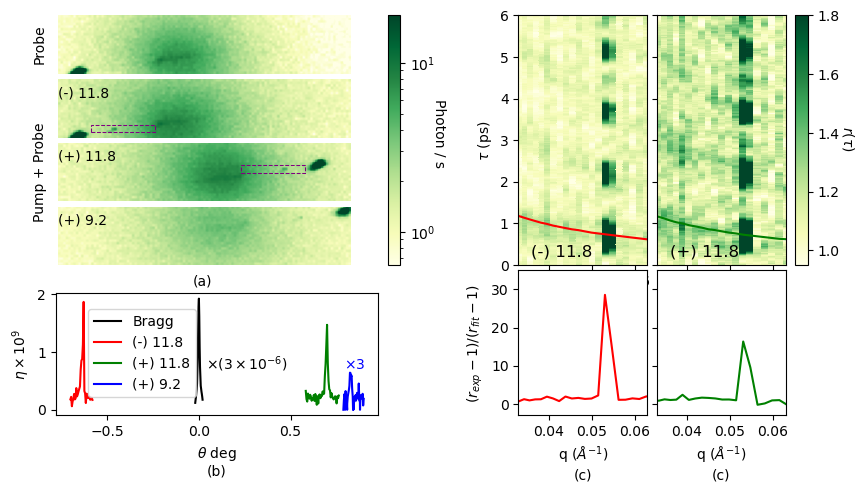

In [9]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(nrows=7, ncols=8,
                      width_ratios=(0.3, 2.5, 0.1, 0.4, 0.3, 1, 1, 0.1),
                      height_ratios=(1, 1, 1, 1, 0.3, 1, 1),
                      left=0.1,
                      right=0.9,
                      bottom=0.1,
                      top=0.9,
                      wspace=0.1,
                      hspace=0.1, )

img_axes = np.array([fig.add_subplot(gs[x, :3]) for x in [0, 1, 2, 3]])
rock_ax = fig.add_subplot(gs[5:, 1])
qt_axes = np.array([fig.add_subplot(gs[:4, 5]),
                    fig.add_subplot(gs[:4, 6]), ])
cmap_ax = fig.add_subplot(gs[:4, 7])

cmap_ax2 = fig.add_subplot(gs[:4, 2])

ratio_axes = np.array([fig.add_subplot(gs[4:, 5], sharex=qt_axes[0]),
                       fig.add_subplot(gs[4:, 6], sharex=qt_axes[1]), ])

# --------------------------------------------------------------------
# Plot the rocking curve
th_bragg = data_rocking['sto220 a'][np.argmax(data_rocking['sto220 I'])]
scaling = 1e9
rock_ax.plot(data_rocking['sto220 a'] - th_bragg, data_rocking['sto220 I'] * scaling * 3e-6, c='k', label='Bragg')
rock_ax.plot(data_rocking['12m a'] - th_bragg, (data_rocking['12m I']) * scaling, c='r', label='(-) 11.8')
rock_ax.plot(data_rocking['12p a'] - th_bragg, (data_rocking['12p I']) * scaling, c='g', label='(+) 11.8')
rock_ax.plot(data_rocking['9p a'] - th_bragg, (data_rocking['9p I']) * 3 * scaling, c='b', label='(+) 9.2')
rock_ax.legend(loc=(0.1, 0.15))
rock_ax.set_xlabel(r'$\theta$ deg' + '\n(b)')
rock_ax.set_ylabel(r'$\eta \times 10^{9}$')
rock_ax.text(x=-4.65 - th_bragg, y=0.7, s=r'$\times (3\times10^{-6})$')
rock_ax.text(x=-3.9 - th_bragg, y=0.7, s=r'$\times 3$', c='b')

# --------------------------------------------------------------------
# Show the 2d detector image
cmap = 'YlGn'
extent = [650, 650 + data_12m['avg_probe_img'].shape[1],
          512 + 102, 512 + 102 + data_12m['avg_probe_img'].shape[0], ]
extent_9 = [729, 729 + 299,
            512 + 3, 512 + 3 + 299]
factor = 6.2415e12 / 9.8e3 * 0.3 * 0.9 * 0.91 * 0.95 * 0.95 * 0.75 * 120
vmin = 5e-11 * factor
vmax = 1.5e-9 * factor

img_axes[0].imshow(probe_12m * factor, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
img_axes[1].imshow(pump_12m * factor, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
img_axes[2].imshow(pump_12p * factor, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
img_2d = img_axes[3].imshow(pump_9p * factor, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent_9)

for idx in range(4):
    img_axes[idx].set_axis_off()
    img_axes[idx].set_xlim([830, 945])
    img_axes[idx].set_ylim([652, 675])

#cbar_img2 = fig.colorbar(img_2d, cax=cmap_ax2, shrink=1.0, label='a', aspect=0.1, anchor=(-1,0))
#cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])
#cmap_ax2.text(x=3.5, y=1.3, s=r"$r(\tau)\equiv \Delta I(t)$ / $I(0)$", rotation=-90)
cbar_img2 = fig.colorbar(img_2d, cax=cmap_ax2, shrink=1.0, location='right')
cmap_ax2.text(x=3.5, y=2.5, s=r"Photon / s", rotation=-90)

square_1 = ptch.Rectangle(xy=(193 + 650, 96 - 56 + 614,), width=25, height=3, color='purple', fill=False,
                          linestyle='--',
                          linewidth=0.75)
img_axes[1].add_patch(square_1)

square_2 = ptch.Rectangle(xy=(238 + 14 + 650, 96 - 46.8 + 614,), width=25, height=3, color='purple', fill=False,
                          linestyle='--',
                          linewidth=0.75)
img_axes[2].add_patch(square_2)

# --------------------------------------------------------------------
# Show the q-t plot
xlim = [0.033, 0.063]
vmax = 0.8 + 1
vmin = -0.05 + 1

q_12m_l = data_12m['qmap'][54, 190]
q_12m_r = data_12m['qmap'][54, 220]

qt_12m = signal.convolve2d(np.sum(data_12m['both_2d'][:, 54:55, 190:220], axis=1), np.ones((20, 1)) / 20., mode='same')
bk_12m = np.mean(qt_12m[:50], axis=0)
qt_12m /= bk_12m[np.newaxis, :]

q_12p_l = data_12p['qmap'][45, 238]
q_12p_r = data_12p['qmap'][45, 278]

qt_12p = signal.convolve2d(np.sum(data_12p['both_2d'][:, 45:46, 238:278], axis=1), np.ones((20, 1)) / 20., mode='same')
bk_12p = np.mean(qt_12p[:50], axis=0)
qt_12p /= bk_12p[np.newaxis, :]

index_left = np.argmax(phi_2_left, axis=0)
peak_time_left = (data_12m['delay_ps'] - param_both.x[2])[index_left]
peak_val_left = np.array([qt_12m[index_left[x], x] for x in range(index_left.shape[0])])
peak_val_left_fit = np.array([fit_2d_12m[index_left[x], x] for x in range(index_left.shape[0])])

index_right = np.argmax(phi_2_right, axis=0)
peak_time_right = (data_12m['delay_ps'] - param_both.x[2])[index_right]
peak_val_right = np.array([qt_12p[index_right[x], x] for x in range(index_right.shape[0])])
peak_val_right_fit = np.array([fit_2d_12p[index_right[x], x] for x in range(index_right.shape[0])])

# --------------------------------------------------------------
im1 = qt_axes[0].pcolor(data_12m['qmap'][54, 190:220] * np.pi * 2,
                        data_12m['delay_ps'] - param_both.x[2],
                        qt_12m,
                        cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        )

qt_axes[0].plot(data_12m['qmap'][54, 190:220] * np.pi * 2, peak_time_left, 'r')

im2 = qt_axes[1].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,
                        data_12p['delay_ps'] - param_both.x[2],
                        qt_12p,
                        cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        )

qt_axes[1].plot(data_12p['qmap'][45, 238:278] * np.pi * 2, peak_time_right, 'g')

qt_axes[0].set_ylabel(r"$\tau$ (ps)")
qt_axes[1].set_yticklabels([])

for idx in range(2):
    qt_axes[idx].set_ylim([0, 6.])
    qt_axes[idx].set_xlim(xlim)

#qt_axes[0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(c)")
#qt_axes[1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(d)")

qt_axes[0].text(x=0.036, y=0.2, s='(-) 11.8', color='k', fontsize=12)
qt_axes[1].text(x=0.036, y=0.2, s='(+) 11.8', color='k', fontsize=12)

cbar_img = fig.colorbar(im2, cax=cmap_ax, shrink=0.001)
#cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])
cmap_ax.text(x=3.5, y=1.35, s=r"$r(\tau)$", rotation=-90)

# Plot the ratio figure
ratio_axes[0].plot(data_12m['qmap'][54, 190:220] * np.pi * 2, (peak_val_left - 1) / (peak_val_left_fit - 1), 'r')
ratio_axes[1].plot(data_12p['qmap'][45, 238:278] * np.pi * 2, (peak_val_right - 1) / (peak_val_right_fit - 1), 'g')

ratio_axes[0].set_ylabel(r"$(r_{exp} - 1) / (r_{fit} - 1)$ ")
ratio_axes[1].set_yticklabels([])

for idx in range(2):
    #ratio_axes[idx].set_xticklabels([])
    ratio_axes[idx].set_xlim(xlim)
    ratio_axes[idx].set_ylim([-3, 35])

ratio_axes[0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(c)")
ratio_axes[1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(c)")

# Add text to the 2d images
img_axes[0].text(x=820, y=657, s='Probe', color='k', rotation=90)
img_axes[2].text(x=820, y=645, s='Pump + Probe', color='k', rotation=90)

img_axes[1].text(x=830, y=668, s='(-) 11.8', color='k', rotation=0)
img_axes[2].text(x=830, y=668, s='(+) 11.8', color='k', rotation=0)
img_axes[3].text(x=830, y=668, s='(+) 9.2', color='k', rotation=0)

img_axes[3].text(x=883, y=644, s='(a)', color='k', rotation=0)

plt.savefig("./fig2.png", bbox_inches='tight', dpi=300)
plt.show()

# Get the new figure 3

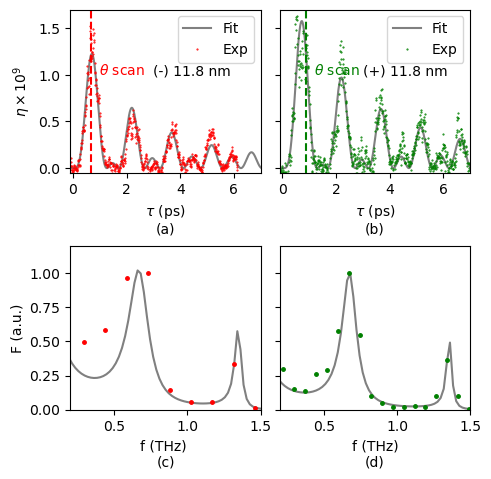

In [10]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(nrows=2, ncols=2,
                      width_ratios=(1, 1,),
                      height_ratios=(1, 1,),
                      left=0.1,
                      right=0.9,
                      bottom=0.1,
                      top=0.9,
                      wspace=0.1,
                      hspace=0.45, )

# --------------------------------------------------------------
time_ax_m = fig.add_subplot(gs[0, 0])
time_ax_p = fig.add_subplot(gs[0, 1])
freq_ax_m = fig.add_subplot(gs[1, 0])
freq_ax_p = fig.add_subplot(gs[1, 1])

# Create a plot for the reflectivity
time_ax_m.plot(t_new - param_both.x[2], (fit_12m - param_12m.x[0]) * 1e-2,
               c='grey', label='Fit', )
time_ax_m.plot(data_12m['delay_ps'] - param_12m.x[2],
               np.convolve((data_12m['both_1d_timeTrace'] - param_12m.x[0] * 1e-11) * 1e9, np.ones(5) / 5, mode='same'),
               c='red', marker='.', linestyle='', markersize=1, label='Exp')
time_ax_m.axvline(x=delay_left, color='r', linestyle='--')
time_ax_m.set_xlim([-0.1, 7])
time_ax_m.set_ylim([-0.05, 1.7])

time_ax_m.set_ylabel(r'$\eta \times 10^{9}$')
time_ax_m.set_xlabel(r"$\tau$ (ps)" + "\n(a)")
time_ax_m.legend()
time_ax_m.text(x=3., y=1, s='(-) 11.8 nm')
time_ax_m.text(x=delay_left + 0.3, y=1, s=r'$\theta$ scan', color='red')

time_ax_p.plot(t_new - param_both.x[2], (fit_12p - param_12p.x[0]) * 1e-2,
               c='grey', label='Fit', )
time_ax_p.plot(data_12p['delay_ps'] - param_12p.x[2],
               np.convolve((data_12p['both_1d_timeTrace'] - param_12p.x[0] * 1e-11) * 1e9, np.ones(5) / 5, mode='same'),
               c='green', marker='.', linestyle='', markersize=1, label='Exp')
time_ax_p.axvline(x=delay_right, color='g', linestyle='--')
time_ax_p.set_xlim([-0.1, 7])
time_ax_p.set_ylim([-0.05, 1.7])
time_ax_p.text(x=3., y=1, s='(+) 11.8 nm')
time_ax_p.text(x=delay_right + 0.3, y=1, s=r'$\theta$ scan', color='green')
time_ax_p.set_yticklabels([])
time_ax_p.set_xlabel(r"$\tau$ (ps)" + "\n(b)")
time_ax_p.legend()

# Create a plot for the reflectivity
idx = np.argmin(np.abs(data_12m['freq_THz'] - param_both.x[4] / np.pi / 2.))

freq_ax_m.plot(f_THz_new, f_fit_12m, c='grey')
freq_ax_m.plot(data_12m['freq_THz'], data_12m['both_1d_spectrum'] / data_12m['both_1d_spectrum'][idx],
               c='red', marker='.', linestyle='', markersize=5)
freq_ax_m.set_xlim([0.2, 1.5])
freq_ax_m.set_ylim([0, 1.2])
freq_ax_m.set_ylabel("F (a.u.)")
freq_ax_m.set_xlabel(r"f (THz) " + "\n(c)")

idx = np.argmin(np.abs(data_12p['freq_THz'] - param_both.x[4] / np.pi / 2.))

freq_ax_p.plot(f_THz_new, f_fit_12p, c='grey')
freq_ax_p.plot(data_12p['freq_THz'], data_12p['both_1d_spectrum'] / data_12p['both_1d_spectrum'][idx],
               c='green', marker='.', linestyle='', markersize=5)
freq_ax_p.set_xlim([0.2, 1.5])
freq_ax_p.set_ylim([0, 1.2])

freq_ax_p.set_xlabel(r"f (THz)" + "\n(d)")
freq_ax_p.set_yticklabels([])

plt.savefig("./fig3.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\haoyu\AppData\Local\Temp\ipykernel_70740\992296463.py:44: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im1 = axes[1, 0].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,
C:\Users\haoyu\AppData\Local\Temp\ipykernel_70740\992296463.py:51: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im2 = axes[1, 1].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,


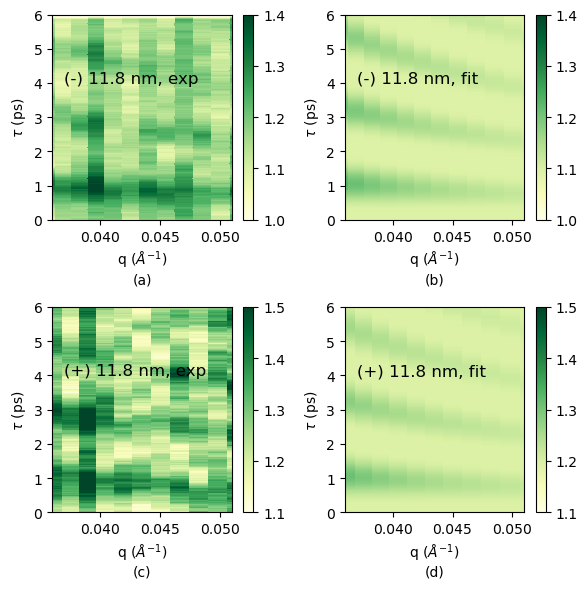

In [21]:
# Get the figure in the appendix
vmin = 0.1 + 1
vmax = 0.5 + 1

t0 = param_both.x[2]
# Get the fitted 2d figure
fit_2d_12m = (param_2d_12m.x[0] +
              param_2d_12m.x[1] * np.exp(- q_left ** 2 * param_2d_12m.x[2]) / (q_left / q_left[0, 0]) ** 0 * (qg_l ** 2)
              * np.square(
            np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.) -
            np.exp(-(t_left - t0) / param_2d_12m.x[3] / 2.)
            * np.cos(q_left * 79.82 * (t_left - t0))
        )
              )

fit_2d_12p = (param_2d_12p.x[0] +
              param_2d_12p.x[1] * np.exp(- q_right ** 2 * param_2d_12p.x[2]) / (q_right / q_right[0, 0]) ** 0 * (
                      qg_r ** 2)
              * np.square(
            np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.) -
            np.exp(-(t_right - t0) / param_2d_12p.x[3] / 2.)
            * np.cos(q_right * 79.82 * (t_right - t0))
        )
              )

cmap = 'YlGn'
# -----------------------------------------
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

im1 = axes[0, 0].pcolor(data_12m['qmap'][54, 190:220] * np.pi * 2,
                        data_12m['delay_ps'] - param_both.x[2],
                        measure_left,
                        cmap=cmap,
                        vmin=vmin - 0.1, vmax=vmax - 0.1)
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].pcolor(data_12m['qmap'][54, 190:220] * np.pi * 2,
                        data_12m['delay_ps'] - param_both.x[2],
                        fit_2d_12m,
                        cmap=cmap,
                        vmin=vmin - 0.1, vmax=vmax - 0.1)
fig.colorbar(im2, ax=axes[0, 1])

im1 = axes[1, 0].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,
                        data_12p['delay_ps'] - param_both.x[2],
                        measure_right,
                        cmap=cmap,
                        vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].pcolor(data_12p['qmap'][45, 238:278] * np.pi * 2,
                        data_12p['delay_ps'] - param_both.x[2],
                        fit_2d_12p,
                        cmap=cmap,
                        vmin=vmin, vmax=vmax)
fig.colorbar(im2, ax=axes[1, 1])

for idx in range(2):
    axes[0, idx].set_ylim([0, 6.])
    axes[0, idx].set_xlim([0.036, 0.051])

for idx in range(2):
    axes[1, idx].set_ylim([0, 6.])
    axes[1, idx].set_xlim([0.036, 0.051])

axes[0, 0].text(x=0.037, y=4, s='(-) 11.8 nm, exp', color='k', fontsize=12)
axes[1, 0].text(x=0.037, y=4, s='(+) 11.8 nm, exp', color='k', fontsize=12)
axes[0, 1].text(x=0.037, y=4, s='(-) 11.8 nm, fit', color='k', fontsize=12)
axes[1, 1].text(x=0.037, y=4, s='(+) 11.8 nm, fit', color='k', fontsize=12)

label = ["(a)", "(b)", "(c)", "(d)"]
for xidx in range(2):
    for yidx in range(2):
        axes[xidx, yidx].set_xlabel(r"q ($\AA^{-1}$)" + "\n" + label[xidx * 2 + yidx])
        axes[xidx, yidx].set_ylabel(r"$\tau$ (ps)")

plt.tight_layout()
plt.savefig("fig_B12.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
param_2d_12m

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 115.32387808694399
       x: [ 1.092e+00  1.004e-02  2.713e+01  1.406e+01]
     nit: 6
   direc: [[ 2.000e+00  7.626e-04  6.994e-01  9.057e-01]
           [ 5.452e-02 -2.012e-05 -1.890e-02  6.398e-02]
           [ 5.911e-02 -3.360e-05 -2.725e-01  1.433e+00]
           [-2.271e-02  3.863e-05  4.220e+00 -1.172e+00]]
    nfev: 520